In [8]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as stats
from scipy.stats import spearmanr

import matplotlib
import matplotlib.pyplot as plt

import trackintel as ti

In [11]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [3]:
FEATURES_COL = [
    "length",
    "dur",
    "speed_av",
    "speed_85th",
    "acc_av",
    "acc_85th",
    "br_av",
    "br_85th",
    "rwStation_se_dist_min",
    "rwStation_se_dist_max",
    "tramStop_se_dist_min",
    "tramStop_se_dist_max",
    "busStop_se_dist_min",
    "busStop_se_dist_max",
    "carParking_se_dist_min",
    "carParking_se_dist_max",
    "bicycleParking_se_dist_min",
    "bicycleParking_se_dist_max",
    "landingStage_se_dist_min",
    "landingStage_se_dist_max",
    "rwStations_dist_av",
    "tramStops_dist_av",
    "busStops_dist_av",
    "poi_dist_av",
    "rwNetwork_dist_av",
    "tramNetwork_dist_av",
    "roadNetwork_dist_av",
    "pbNetwork_dist_av",
    "water_ovlp_prop",
    'greenSpaces_poly_dist', 
    'residental_poly_dist', 
    'forest_poly_dist'
]

FEATURES_SIMBOL = [
    "1.1 $D$",
    "1.2 $T$",
    "1.3 $\overline{V}$",
    "1.4 $V^{85^{th}}$",
    "1.5 $\overline{A}$",
    "1.6 $A^{85^{th}}$",
    "1.7 $\overline{B}$",
    "1.8 $B^{85^{th}}$",
    "2.1 $D^{min}_{rail}$",
    "2.2 $D^{max}_{rail}$",
    "2.3 $D^{min}_{tram}$",
    "2.4 $D^{max}_{tram}$",
    "2.5 $D^{min}_{bus}$",
    "2.6 $D^{max}_{bus}$",
    "2.7 $D^{min}_{car}$",
    "2.8 $D^{max}_{car}$",
    "2.9 $D^{min}_{bike}$",
    "2.10 $D^{max}_{bike}$",
    "2.11 $D^{min}_{ship}$",
    "2.12 $D^{max}_{ship}$",
    "2.13 $D_{railS}$",
    "2.14 $D_{tramS}$",
    "2.15 $D_{busS}$",
    "2.16 $D_{POIS}$",
    "2.17 $D_{railN}$",
    "2.18 $D_{tramN}$",
    "2.19 $D_{roadN}$",
    "2.20 $D_{pedN}$",
    "2.21 $P_{water}$",
    "2.22 $D_{green}$",
    "2.23 $D_{resident}$",
    "2.24 $D_{forest}$",
]

FEATURES_NUM = [
    "1.1",
    "1.2",
    "1.3",
    "1.4",
    "1.5",
    "1.6",
    "1.7",
    "1.8",
    "2.1",
    "2.2",
    "2.3",
    "2.4",
    "2.5",
    "2.6",
    "2.7",
    "2.8",
    "2.9",
    "2.10",
    "2.11",
    "2.12",
    "2.13",
    "2.14",
    "2.15",
    "2.16",
    "2.17",
    "2.18",
    "2.19",
    "2.20",
    "2.21",
    "2.22",
    "2.23",
    "2.24",
]

order = ['Bicycle', 'Boat', 'Bus', 'Car', 'Train', 'Tram', 'Walk']

# save
if not os.path.exists("fig"):
    os.makedirs("fig")

# Visualize data quality

In [4]:
tl = ti.io.file.read_triplegs_csv(
    os.path.join("data", "triplegs_preprocessed.csv"), index_col="index", geom_col="geom", crs=4326
)
tl.rename(columns={"dur_s": "dur"}, inplace=True)

In [7]:
tl["count"] = [len(geom.coords) for geom in tl["geom"]]
freq = tl["dur"]/tl["count"]
density = stats.gaussian_kde(freq)

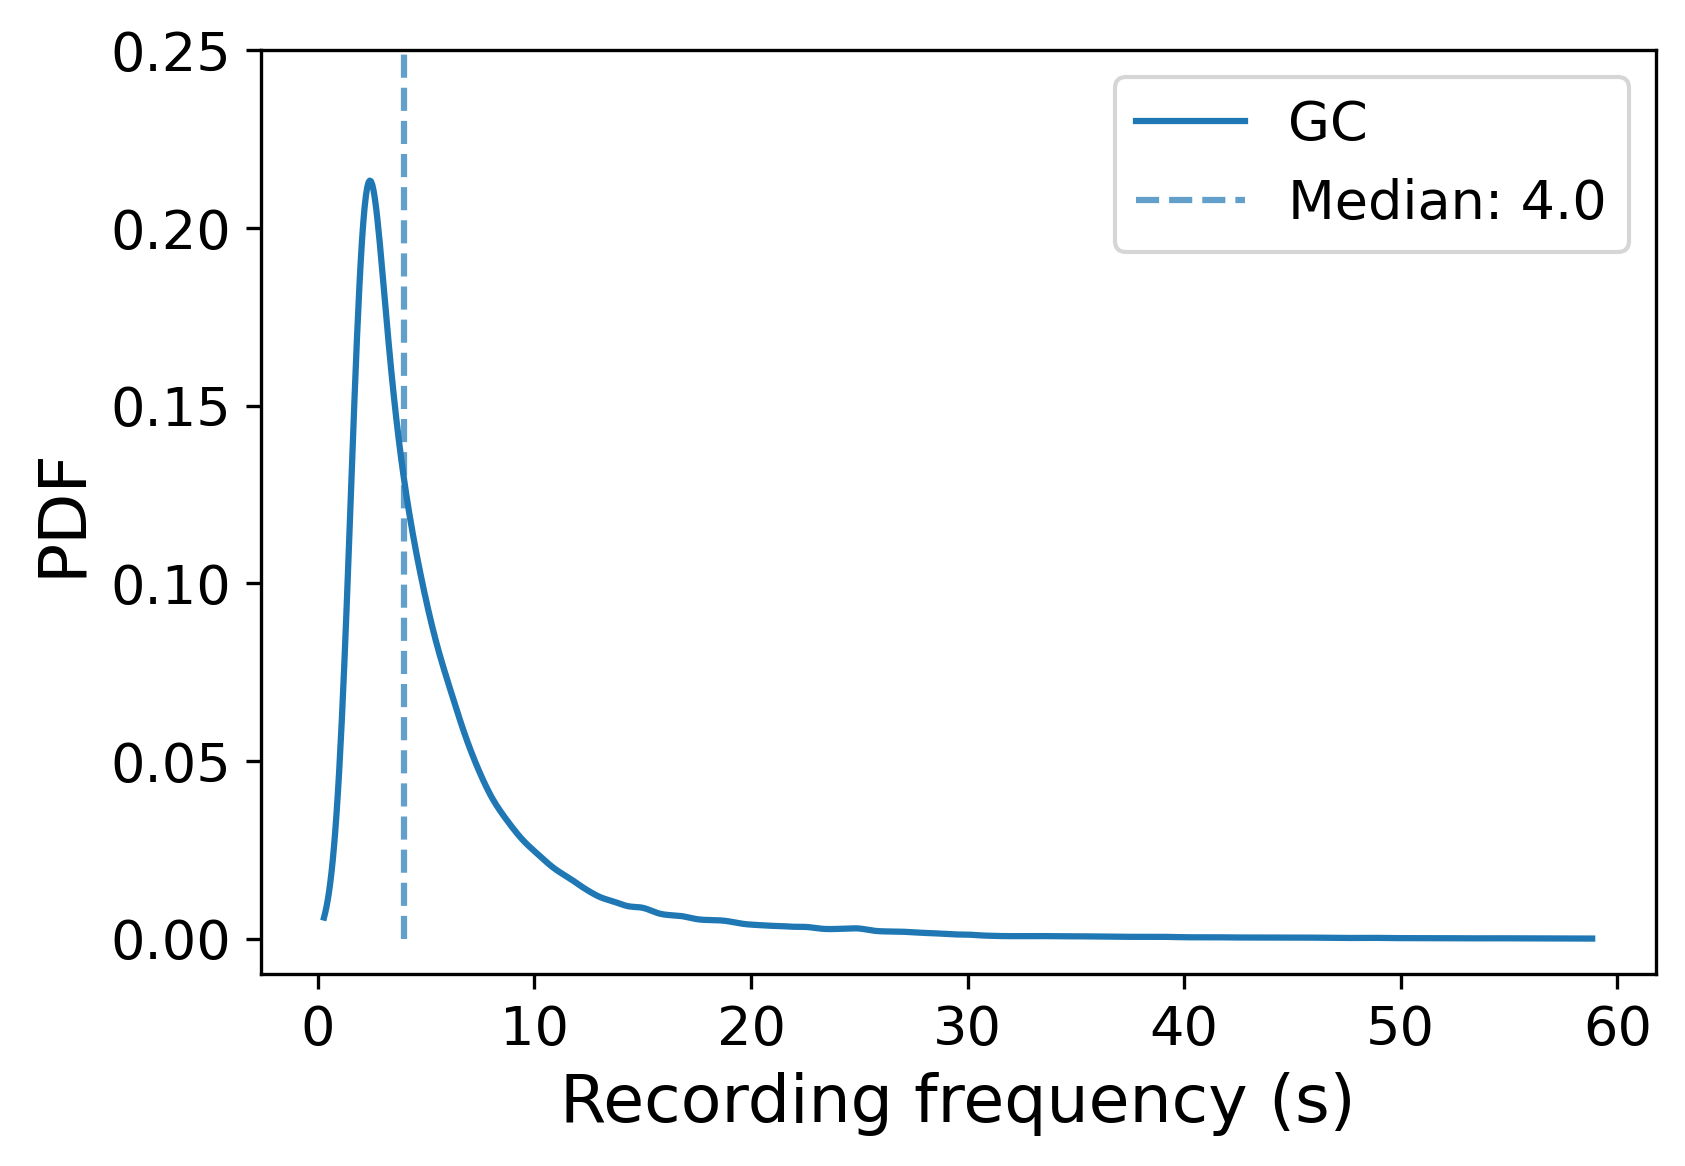

In [25]:
x = np.linspace(np.min(freq), np.max(freq), 1000)

fig, ax = plt.subplots(figsize=(6,4))

plt.plot(x, density(x), color=colors[0], label="GC")
plt.vlines(x=freq.median(), ymin=0, ymax=0.3, alpha=0.7, linestyle="dashed", color=colors[0], label=f"Median: {freq.median():.1f}")
# plt.fill_between(x, 0, freq(x), alpha=0.2)
plt.legend(loc="upper right", fontsize=13)
plt.xlabel("Recording frequency (s)", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.ylim([-0.01, 0.25])
plt.savefig(os.path.join("fig", "freq.png"), bbox_inches='tight', dpi=600)

plt.show()

# Visualize features

In [4]:
def add_values(bp, ax, decimal=0):
    """ This actually adds the numbers to the various points of the boxplots"""
    for line in bp['medians']:
        # Get the position of the element. y is the label you want
        (x_l, y),(x_r, _) = line.get_xydata()
        # Make sure datapoints exist 
        if not np.isnan(y): 
            x_line_center = x_l + (x_r - x_l)/2 + 0.2
            y_line_center = y  # Since it's a line and it's horisontal
            # overlay the value:  on the line, from center to right
            ax.text(x_line_center, y_line_center, # Position
                    f'%.{decimal}f' % y, # Value (3f = 3 decimal float)
                    verticalalignment='center', # Centered vertically with line 
                    fontsize=11, backgroundcolor="white")

## Load data

In [5]:
tl = pd.read_csv(os.path.join("data", "triplegs_features.csv"), index_col="index")

In [6]:
tl['mode'] = tl['mode'].replace({
    'Mode::Car': 'Car',
    'Mode::Ecar': 'Car',
    'Mode::Bicycle': 'Bicycle',
    'Mode::Ebicycle': 'Bicycle',
    'Mode::Walk': 'Walk',
    'Mode::Train': 'Train',
    'Mode::Tram': 'Tram',
    'Mode::Bus': 'Bus',
    'Mode::Boat': 'Boat'
})

## Acceleration 85 percentile

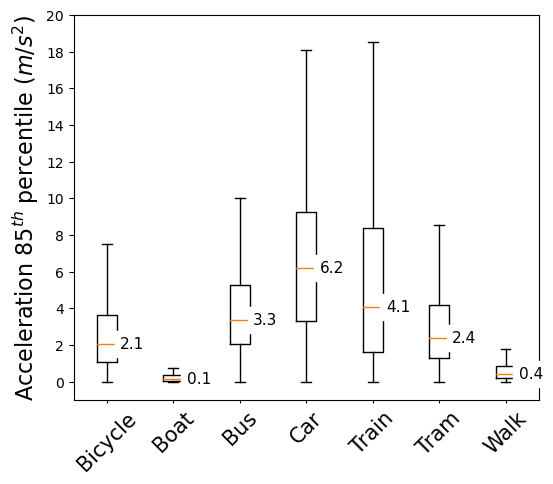

In [6]:
column_name='acc_85th'

data = (
    tl[tl["mode"] == 'Bicycle'][column_name],
    tl[tl["mode"] == 'Boat'][column_name],
    tl[tl["mode"] == 'Bus'][column_name],
    tl[tl["mode"] == 'Car'][column_name],
    tl[tl["mode"] == 'Train'][column_name],
    tl[tl["mode"] == 'Tram'][column_name],
    tl[tl["mode"] == 'Walk'][column_name],
)

fig, ax = plt.subplots(figsize=(6,5))

ind = np.arange(len(data))
width = 0.3
space = 0.3

x = list()
for i in ind:
    x.extend([i])

bp_dict = plt.boxplot(data, positions=ind, widths=width, showfliers=False)
add_values(bp_dict, ax, decimal=1)

plt.ylim(-1, 20)
plt.yticks(np.arange(0, 21, 2))

ax.set_xticklabels(order, ha='center', rotation = 45, fontsize = 15)
ax.tick_params(axis='x', which='both',length=2)

plt.ylabel('Acceleration 85$^{th}$ percentile $(m/s^2)$', fontsize = 16)

plt.savefig(os.path.join("fig", "feature_acceler_85.png"), bbox_inches='tight', dpi=600)

plt.show()

## Distance of Start/End Point to Tram Stop

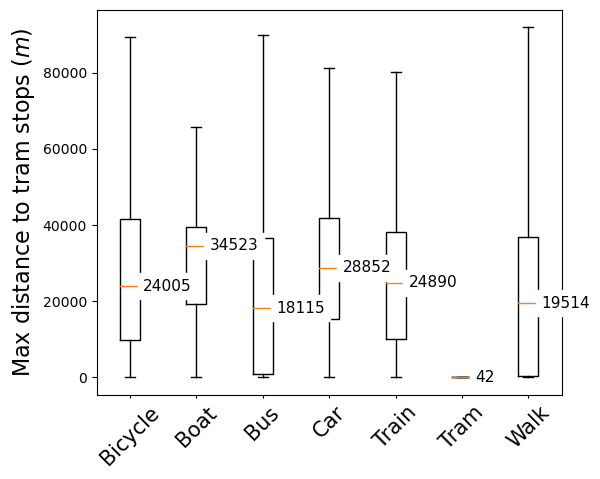

In [7]:
column_name='tramStop_se_dist_max'

data = (
    tl[tl["mode"] == 'Bicycle'][column_name],
    tl[tl["mode"] == 'Boat'][column_name],
    tl[tl["mode"] == 'Bus'][column_name],
    tl[tl["mode"] == 'Car'][column_name],
    tl[tl["mode"] == 'Train'][column_name],
    tl[tl["mode"] == 'Tram'][column_name],
    tl[tl["mode"] == 'Walk'][column_name],
)

fig, ax = plt.subplots(figsize=(6,5))

ind = np.arange(len(data))
width = 0.3
space = 0.3

x = list()
for i in ind:
    x.extend([i])


bp_dict = plt.boxplot(data, positions=ind, widths=width, showfliers=False)
add_values(bp_dict, ax, decimal=0)


ax.set_xticklabels(order, ha='center', rotation = 45, fontsize = 15)
ax.tick_params(axis='x', which='both',length=2)

plt.ylabel("Max distance to tram stops $(m)$", fontsize = 16)

plt.savefig(os.path.join("fig", "feature_tram_points.png"), bbox_inches='tight', dpi=600)

plt.show()

## Average Distance of Track Points to Road Network

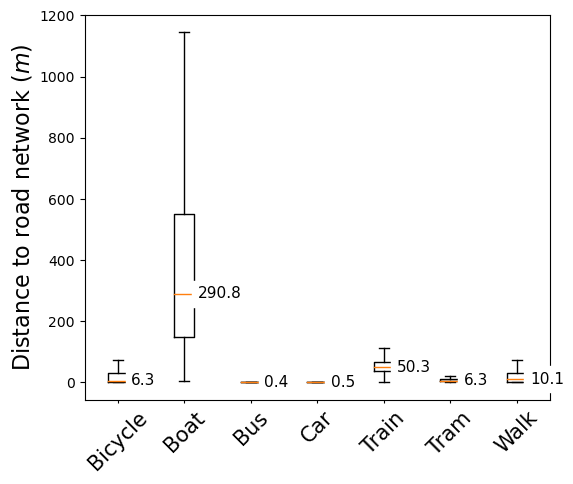

In [8]:
column_name='roadNetwork_dist_av'

data = (
    tl[tl["mode"] == 'Bicycle'][column_name],
    tl[tl["mode"] == 'Boat'][column_name],
    tl[tl["mode"] == 'Bus'][column_name],
    tl[tl["mode"] == 'Car'][column_name],
    tl[tl["mode"] == 'Train'][column_name],
    tl[tl["mode"] == 'Tram'][column_name],
    tl[tl["mode"] == 'Walk'][column_name],
)

fig, ax = plt.subplots(figsize=(6,5))

ind = np.arange(len(data))
width = 0.3
space = 0.3

x = list()
for i in ind:
    x.extend([i])

bp_dict = plt.boxplot(data, positions=ind, widths=width, showfliers=False)
add_values(bp_dict, ax, decimal=1)

ax.set_xticklabels(order, ha='center', rotation = 45, fontsize = 15)
ax.tick_params(axis='x', which='both',length=2)

plt.ylabel("Distance to road network $(m)$", fontsize = 16)

plt.savefig(os.path.join("fig", "feature_road_net.png"), bbox_inches='tight', dpi=600)

plt.show()

# Visualize correlations

## Load data

In [3]:
tl = pd.read_csv(os.path.join("data", "triplegs_features.csv"), index_col="index")
tl_data = tl[FEATURES_COL].copy()

## Calculate correlation

In [4]:
corr = spearmanr(tl_data).correlation

# create a lower triangle matrix
condition = np.tril(np.ones((corr.shape)), k = -1).astype(bool)
triangle = np.where(condition, corr, np.nan)

In [11]:
p = spearmanr(tl_data).pvalue
p[28,13]

0.1338825836696111

In [12]:
FEATURES_NUM[28], FEATURES_NUM[13]

('2.21', '2.6')

## Visualize

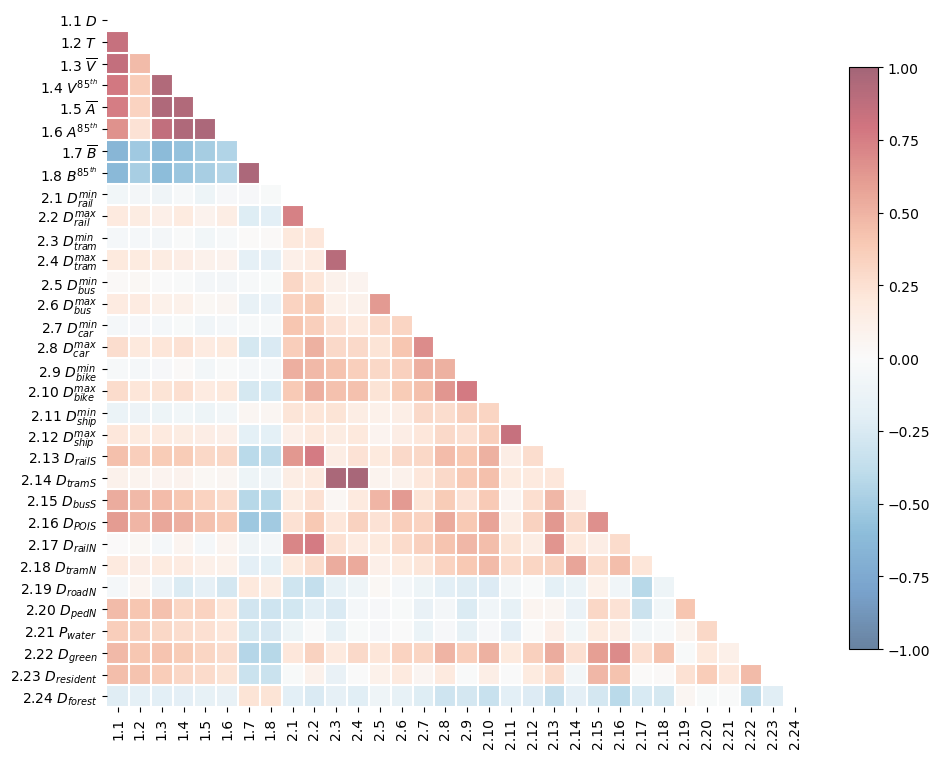

In [23]:
fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, axes_class=axisartist.Axes)
ax = fig.add_subplot(111)

# extent = (0, len(features), len(features), 0)
test = ax.imshow(triangle, cmap="RdBu_r", alpha=0.6)

idx = np.arange(len(FEATURES_SIMBOL))
ax.set_xticks(idx)
ax.set_yticks(idx)

ax.set_xticklabels(FEATURES_NUM, rotation="vertical")
ax.set_yticklabels(FEATURES_SIMBOL)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.colorbar(test, shrink=0.6)
test.set_clim(-1,1)

plt.hlines(y=np.arange(0, len(FEATURES_NUM))+0.5, xmin=np.full(len(FEATURES_NUM), 0)-0.5, xmax=np.full(len(FEATURES_NUM), len(FEATURES_NUM))-0.5, color="white")
plt.vlines(x=np.arange(0, len(FEATURES_NUM))+0.5, ymin=np.full(len(FEATURES_NUM), 0)-0.5, ymax=np.full(len(FEATURES_NUM), len(FEATURES_NUM))-0.5, color="white")

fig.tight_layout()

plt.savefig(os.path.join("fig", "correlation.png"), bbox_inches='tight', dpi=600)

plt.show()

# Visualize hyperparameters

## Load data

In [13]:
tl = pd.read_csv(os.path.join("data", "triplegs_features.csv"), index_col="index")
tl_data = tl[FEATURES_COL].copy()
tl_target = tl['mode'].replace({
    'Mode::Car': 'Car',
    'Mode::Ecar': 'Car',
    'Mode::Bicycle': 'Bicycle',
    'Mode::Ebicycle': 'Bicycle',
    'Mode::Walk': 'Walk',
    'Mode::Train': 'Train',
    'Mode::Tram': 'Tram',
    'Mode::Bus': 'Bus',
    'Mode::Boat': 'Boat'
})

X = tl_data
y = tl_target

In [14]:
# split data into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
y_train.value_counts()

Walk       124068
Car        104557
Train       41222
Bicycle      9587
Bus          7533
Tram         4991
Boat          287
Name: mode, dtype: int64

## Evaluate effect of single parameter: maximal depth

### Balanced

In [15]:
parameters = {'max_depth':np.arange(10, 30)}
rf_base = RandomForestClassifier(random_state=56, n_estimators=150, class_weight='balanced', n_jobs=-2)
clf1 = GridSearchCV(rf_base, parameters, scoring='f1_macro', verbose=4, n_jobs=-2)
clf1.fit(X_train, y_train)
df1 = pd.DataFrame(clf1.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


### Normal

In [16]:
parameters = {'max_depth':np.arange(10, 30)}
rf_base = RandomForestClassifier(random_state=56, n_estimators=150, class_weight=None, n_jobs=-2)
clf1_not_balanced = GridSearchCV(rf_base, parameters, scoring='f1_macro', verbose=4, n_jobs=-2)
clf1_not_balanced.fit(X_train, y_train)
df1_not_balanced = pd.DataFrame(clf1_not_balanced.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


### Visualize

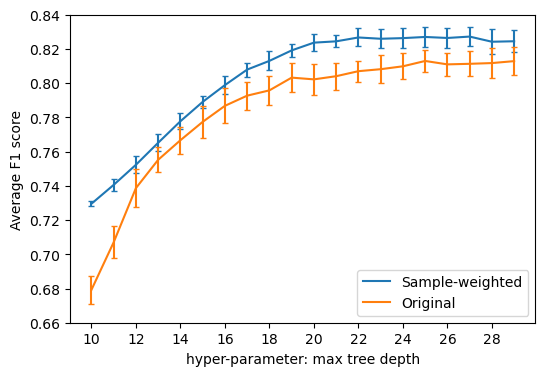

In [22]:
# plot F1 score against max depth
ax = df1.plot(x='param_max_depth', y='mean_test_score', yerr="std_test_score", capsize=2, figsize=(6,4), label="Sample-weighted")
df1_not_balanced.plot(x='param_max_depth', y='mean_test_score', yerr="std_test_score", ax= ax, capsize=2, label="Original")

plt.xlabel('hyper-parameter: max tree depth')
plt.ylabel('Average F1 score')
plt.xticks(np.arange(10, 30, 2))
plt.yticks(np.arange(0.66, 0.85, 0.02))
plt.ylim([0.66, 0.84])
plt.savefig(os.path.join("fig", "hyper_tree.png"), bbox_inches='tight', dpi=600)

plt.show()

## Evaluate effect of single parameter: number of estimators 

### Balanced

In [18]:
parameters = {'n_estimators': np.arange(10, 301, 10)}
rf_base = RandomForestClassifier(random_state=56, max_depth=21, class_weight='balanced', n_jobs=-1)
clf2 = GridSearchCV(rf_base, parameters, scoring='f1_macro', verbose=4, n_jobs=-1)
clf2.fit(X_train, y_train)
df2 = pd.DataFrame(clf2.cv_results_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


### Normal

In [19]:
parameters = {'n_estimators': np.arange(10, 301, 10)}
rf_base = RandomForestClassifier(random_state=56, max_depth=21, class_weight=None, n_jobs=-1)
clf2_not_balanced = GridSearchCV(rf_base, parameters, scoring='f1_macro', verbose=4, n_jobs=-1)
clf2_not_balanced.fit(X_train, y_train)
df2_not_balanced = pd.DataFrame(clf2_not_balanced.cv_results_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


### Visualize

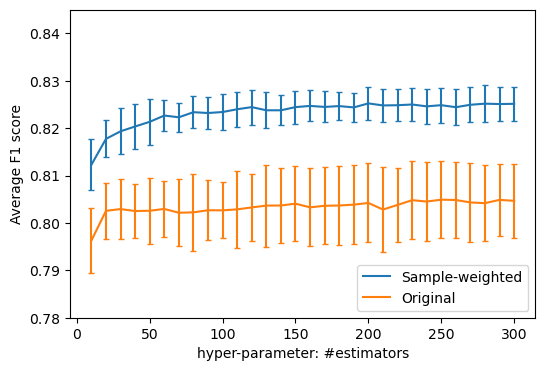

In [21]:
ax = df2.plot(x='param_n_estimators', y='mean_test_score', yerr="std_test_score", capsize=2, figsize=(6,4), label="Sample-weighted")
df2_not_balanced.plot(x='param_n_estimators', y='mean_test_score', yerr="std_test_score", ax=ax, capsize=2, label="Original")

plt.xlabel('hyper-parameter: #estimators')
plt.ylabel('Average F1 score')

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]

plt.ylim([0.78, 0.845])
plt.legend(handles, labels, loc=4)

plt.savefig(os.path.join("fig", "hyper_num.png"), bbox_inches='tight', dpi=600)
plt.show()